In [2]:
import pandas as pd
import numpy as np
import json

#### Getting keys

In [4]:
def analyze_json_structure(data, key_prefix=''):
    """
    Analyzes the structure of JSON data and identifies the main repeating components.

    Args:
    - data: JSON data (dictionary or list)
    - key_prefix: Prefix for the current key (used in recursive calls)

    Returns:
    - Dictionary containing information about the structure
    """
    structure = {}

    if isinstance(data, dict):
        for key, value in data.items():
            new_key = f"{key_prefix}.{key}" if key_prefix else key
            if isinstance(value, (dict, list)):
                structure[new_key] = analyze_json_structure(value, new_key)
            else:
                structure[new_key] = type(value).__name__
    elif isinstance(data, list):
        if data:
            structure[key_prefix] = analyze_json_structure(data[0], key_prefix)
        else:
            structure[key_prefix] = 'Empty List'

    return structure

# Load JSON data from file
with open('annotations\\train_test2017.json', 'r') as f:
    json_data = json.load(f)

# Analyze the structure of the JSON data
json_structure = analyze_json_structure(json_data)

# Print the structure
print(json_structure)


{'info': {'info.description': 'NoneType', 'info.url': 'NoneType', 'info.version': 'NoneType', 'info.year': 'int', 'info.contributor': 'NoneType', 'info.date_created': 'str'}, 'licenses': {'licenses': {'licenses.url': 'NoneType', 'licenses.id': 'int', 'licenses.name': 'NoneType'}}, 'images': {'images': {'images.license': 'int', 'images.url': 'NoneType', 'images.file_name': 'str', 'images.height': 'int', 'images.width': 'int', 'images.date_captured': 'NoneType', 'images.id': 'int'}}, 'type': 'str', 'annotations': {'annotations': {'annotations.id': 'int', 'annotations.image_id': 'int', 'annotations.category_id': 'int', 'annotations.segmentation': {'annotations.segmentation': {'annotations.segmentation': {}}}, 'annotations.area': 'float', 'annotations.bbox': {'annotations.bbox': {}}, 'annotations.iscrowd': 'int'}}, 'categories': {'categories': {'categories.supercategory': 'NoneType', 'categories.id': 'int', 'categories.name': 'str'}}}


#### Mapping the annotations with images

In [5]:
import json
import cv2

# Load JSON data from file
with open('annotations\\train_test2017.json', 'r') as f:
    data = json.load(f)

# Access images and annotations
images_data = data['images']
annotations_data = data['annotations']

# Load images and process annotations
for image_info in images_data:
    image_id = image_info['id']
    file_name = image_info['file_name']
    height = image_info['height']
    width = image_info['width']

    # Load image using OpenCV or PIL
    image = cv2.imread('JPEGImages/' + file_name)  # Adjust path as per your file structure

    print(f"Loaded image: {file_name}")
    print(f"Image ID: {image_id}")
    print(f"Image dimensions: {height} x {width}")

    # Process annotations for this image
    image_annotations = [annotation for annotation in annotations_data if annotation['image_id'] == image_id]
    print(f"Number of annotations for this image: {len(image_annotations)}")

    for annotation in image_annotations:
        category_id = annotation['category_id']
        segmentation = annotation['segmentation']
        area = annotation['area']
        bbox = annotation['bbox']
        is_crowd = annotation['iscrowd']

        print(f"Annotation - Category ID: {category_id}, Area: {area}, Bounding Box: {bbox}, Is Crowd: {is_crowd}")

    print("="*50)  # Separator between images

# Use image and annotations for your model training or evaluation


Loaded image: P0001_0_800_10190_10990.jpg
Image ID: 0
Image dimensions: 800 x 800
Number of annotations for this image: 2
Annotation - Category ID: 1, Area: 260.0, Bounding Box: [237.0, 79.0, 42.0, 8.0], Is Crowd: 0
Annotation - Category ID: 1, Area: 1058.0, Bounding Box: [157.0, 96.0, 93.0, 25.0], Is Crowd: 0
Loaded image: P0001_0_800_7200_8000.jpg
Image ID: 1
Image dimensions: 800 x 800
Number of annotations for this image: 13
Annotation - Category ID: 1, Area: 61.0, Bounding Box: [603.0, 556.0, 8.0, 10.0], Is Crowd: 0
Annotation - Category ID: 1, Area: 276.0, Bounding Box: [465.0, 64.0, 12.0, 34.0], Is Crowd: 0
Annotation - Category ID: 1, Area: 78.0, Bounding Box: [595.0, 550.0, 8.0, 13.0], Is Crowd: 0
Annotation - Category ID: 1, Area: 35.0, Bounding Box: [636.0, 557.0, 4.0, 11.0], Is Crowd: 0
Annotation - Category ID: 1, Area: 67.0, Bounding Box: [583.0, 557.0, 7.0, 13.0], Is Crowd: 0
Annotation - Category ID: 1, Area: 44.0, Bounding Box: [632.0, 555.0, 5.0, 10.0], Is Crowd: 0
An

#### Seeing any 5 images

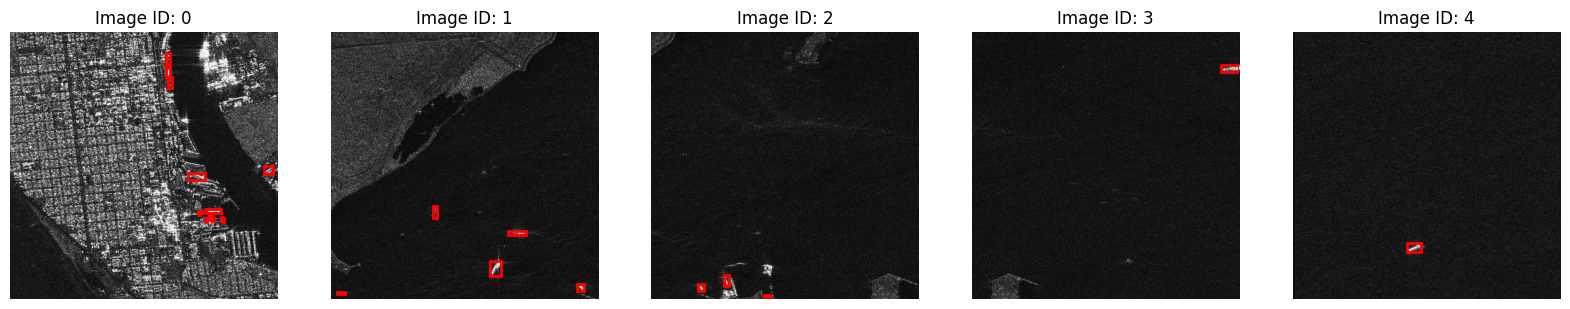

In [6]:
# Display any 5 images and their corresponding annotations
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load JSON data from file
with open('annotations/train2017.json', 'r') as f:
    data = json.load(f)

# Access images and annotations
images_data = data['images']
annotations_data = data['annotations']

# Load and display images
num_images_to_display = 5
fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 5))

for i in range(num_images_to_display):
    # Load image using OpenCV or PIL
    image_info = images_data[i]
    file_name = image_info['file_name']
    image = cv2.imread('JPEGImages/' + file_name)  # Adjust path as per your file structure

    # Display image
    axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Image ID: {image_info['id']}")
    axes[i].axis('off')

    # Process annotations for this image
    image_annotations = [annotation for annotation in annotations_data if annotation['image_id'] == image_info['id']]

    # Display annotations
    for annotation in image_annotations:
        bbox = annotation['bbox']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        axes[i].add_patch(rect)

plt.show()

#### Convert annotations to yolo format (done on terminal)

#### Splitting into train and test

In [11]:
import os
import shutil
import random

# Specify paths for image and annotation directories
image_dir = 'JPEGImages'
annotation_dir = 'converted_annotations'

# Define the split ratio
split_ratio = 0.2

# Set random seed for reproducibility
random.seed(42)

# Get the list of image files
image_files = os.listdir(image_dir)

# Shuffle the list of image files
random.shuffle(image_files)

# Calculate the number of images for validation
num_val_images = int(len(image_files) * split_ratio)

# Split the list of image files into training and validation sets
train_image_files = image_files[:-num_val_images]
val_image_files = image_files[-num_val_images:]

# Create directories for training and validation sets if they don't exist
train_image_output_dir = 'dataset_newplit\\images\\train'
val_image_output_dir = 'dataset_newplit\\images\\val'
train_annotation_output_dir = 'dataset_newplit\\labels\\train'
val_annotation_output_dir = 'dataset_newplit\\labels\\val'

os.makedirs(train_image_output_dir, exist_ok=True)
os.makedirs(val_image_output_dir, exist_ok=True)
os.makedirs(train_annotation_output_dir, exist_ok=True)
os.makedirs(val_annotation_output_dir, exist_ok=True)

# Copy images to training and validation directories
for image_file in train_image_files:
    shutil.copy(os.path.join(image_dir, image_file), os.path.join(train_image_output_dir, image_file))

for image_file in val_image_files:
    shutil.copy(os.path.join(image_dir, image_file), os.path.join(val_image_output_dir, image_file))

# Copy corresponding annotation files to training and validation directories
for image_file in train_image_files:
    annotation_file = os.path.splitext(image_file)[0] + '.txt'
    shutil.copy(os.path.join(annotation_dir, annotation_file), os.path.join(train_annotation_output_dir, annotation_file))

for image_file in val_image_files:
    annotation_file = os.path.splitext(image_file)[0] + '.txt'
    shutil.copy(os.path.join(annotation_dir, annotation_file), os.path.join(val_annotation_output_dir, annotation_file))

print("Data splitting and copying completed.")

Data splitting and copying completed.


In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('best.pt')  # pretrained YOLOv8n model

# Run batched inference on a list of images
results = model(['im1.jpg', 'im2.jpg'])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs

In [6]:
# from ultralytics import YOLO

# model = YOLO('yolov8n.pt')
# model.train(data='config.yaml', epochs=50, device = 'cpu', patience = 5, seed = 42, dropout = 0.2)
# path = model.export()

Ultralytics YOLOv8.1.11 🚀 Python-3.12.1 torch-2.2.0+cpu CPU (AMD Ryzen 7 7735HS with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=config.yaml, epochs=50, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

train: Scanning G:\SAR\HRSID_jpg\dataset\labels\train.cache... 3642 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3642/3642 [00:00<?, ?it/s]
val: Scanning G:\SAR\HRSID_jpg\dataset\labels\val.cache... 1961 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1961/1961 [00:00<?, ?it/s]

Plotting labels to runs\detect\train7\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train7
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.389      1.781       1.02         20        640: 100%|██████████| 228/228 [15:34<00:00,  4.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [03:21<00:00,  3.25s/it]


                   all       1961       5922      0.759      0.618      0.708      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.326      1.122      1.012         22        640: 100%|██████████| 228/228 [15:06<00:00,  3.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [03:08<00:00,  3.04s/it]

                   all       1961       5922      0.823      0.616      0.726      0.456


OSError: [WinError 433] A device which does not exist was specified: 'runs\\detect\\train7\\results.csv'

In [1]:
# show pytorch version
import torch
print(torch.__version__)


2.2.0+cpu
